# part0: imports

In [1]:
import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.WARNING)
from IPython.display import display, clear_output

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator
from matplotlib.collections import LineCollection
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

import pyaldata as pyal


try:
    nbPath = pathlib.Path.cwd()
    RepoPath = nbPath.parent
    os.chdir(RepoPath)

    from tools import utilityTools as utility
    from tools import dataTools as dt
    import params
    monkey_defs = params.monkey_defs
    mouse_defs = params.mouse_defs
    
    os.chdir(params.repoPath / 'monkey')
    %run "_dataset-selection.ipynb"
    
    set_rc =  params.set_rc_params
    set_rc()
    root = params.root
finally:
    os.chdir(nbPath)

if "__file__" not in dir():
    reload(dt)
    reload(mouse_defs)
    reload(monkey_defs)
    print('Done!')

the variable `GoodDataList` contains the session names
Done!


# Behavioural Correlations Functions

In [2]:
try:
    os.chdir(params.repoPath / 'monkey')
    %run "_monkey-corr.ipynb"
    
    defs = params.mouse_defs
    os.chdir(params.repoPath / 'mouse')
    %run "_mouse-corr.ipynb"
finally:
    os.chdir(params.repoPath / 'common')


# Read data and Load decoding data

In [8]:
try:
    os.chdir(params.repoPath / 'monkey')
    %run "MCx-decoding.ipynb"
    monkey_df, monkey_index, monkey_decode = allDFs, pairIndex_across, pop_score_across
    del allDFs, pairIndex_across, pop_score_across
    
    os.chdir(params.repoPath / 'mouse')
    %run "mouse-M1-decoding.ipynb"
    mouse_df, mouse_index, mouse_decode = AllDFs, pairIndex_across, pop_score_across
    del AllDFs, pairIndex_across, pop_score_across
finally:
    os.chdir(params.repoPath / 'common')


# Calculate the correlations

In [4]:
if "__file__" not in dir():
    across_corrs_mice = trim_across_mouse_corr (mouse_df)
    
    defs = params.monkey_defs
    
    across_corrs_monkeys = trim_across_monkey_corr (monkey_df)

/tmp/ipykernel_5566/3524551333.py:27: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1157]
  df2 = pyal.restrict_to_interval(df2__, epoch_fun=defs.exec_epoch)
/tmp/ipykernel_5566/3524551333.py:23: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1157]
  df1 = pyal.restrict_to_interval(df1__, epoch_fun=defs.exec_epoch)


# Assemble the data structure

In [9]:
corr_mice=[]
for i, (id1, testId) in enumerate(mouse_index):
    df1, df2 = mouse_df[id1] , mouse_df[testId]
    behav = np.array(across_corrs_mice[df1.file[0]][df2.file[0]])
    behav = behav[behav>params.Behav_corr_TH]
    decode = mouse_decode[i]
    corr_mice.append((decode , np.mean(behav)))
corr_mice = np.array(corr_mice)


corr_monkey=[]
for i, (id1, testId) in enumerate(monkey_index):
    df1, df2 = monkey_df[id1] , monkey_df[testId]
    behav = np.array(across_corrs_monkeys[df1.session[0]][df2.session[0]])
    behav = behav[behav>params.Behav_corr_TH]
    decode = monkey_decode[i]
    corr_monkey.append((decode , np.mean(behav)))
corr_monkey = np.array(corr_monkey)

# plot

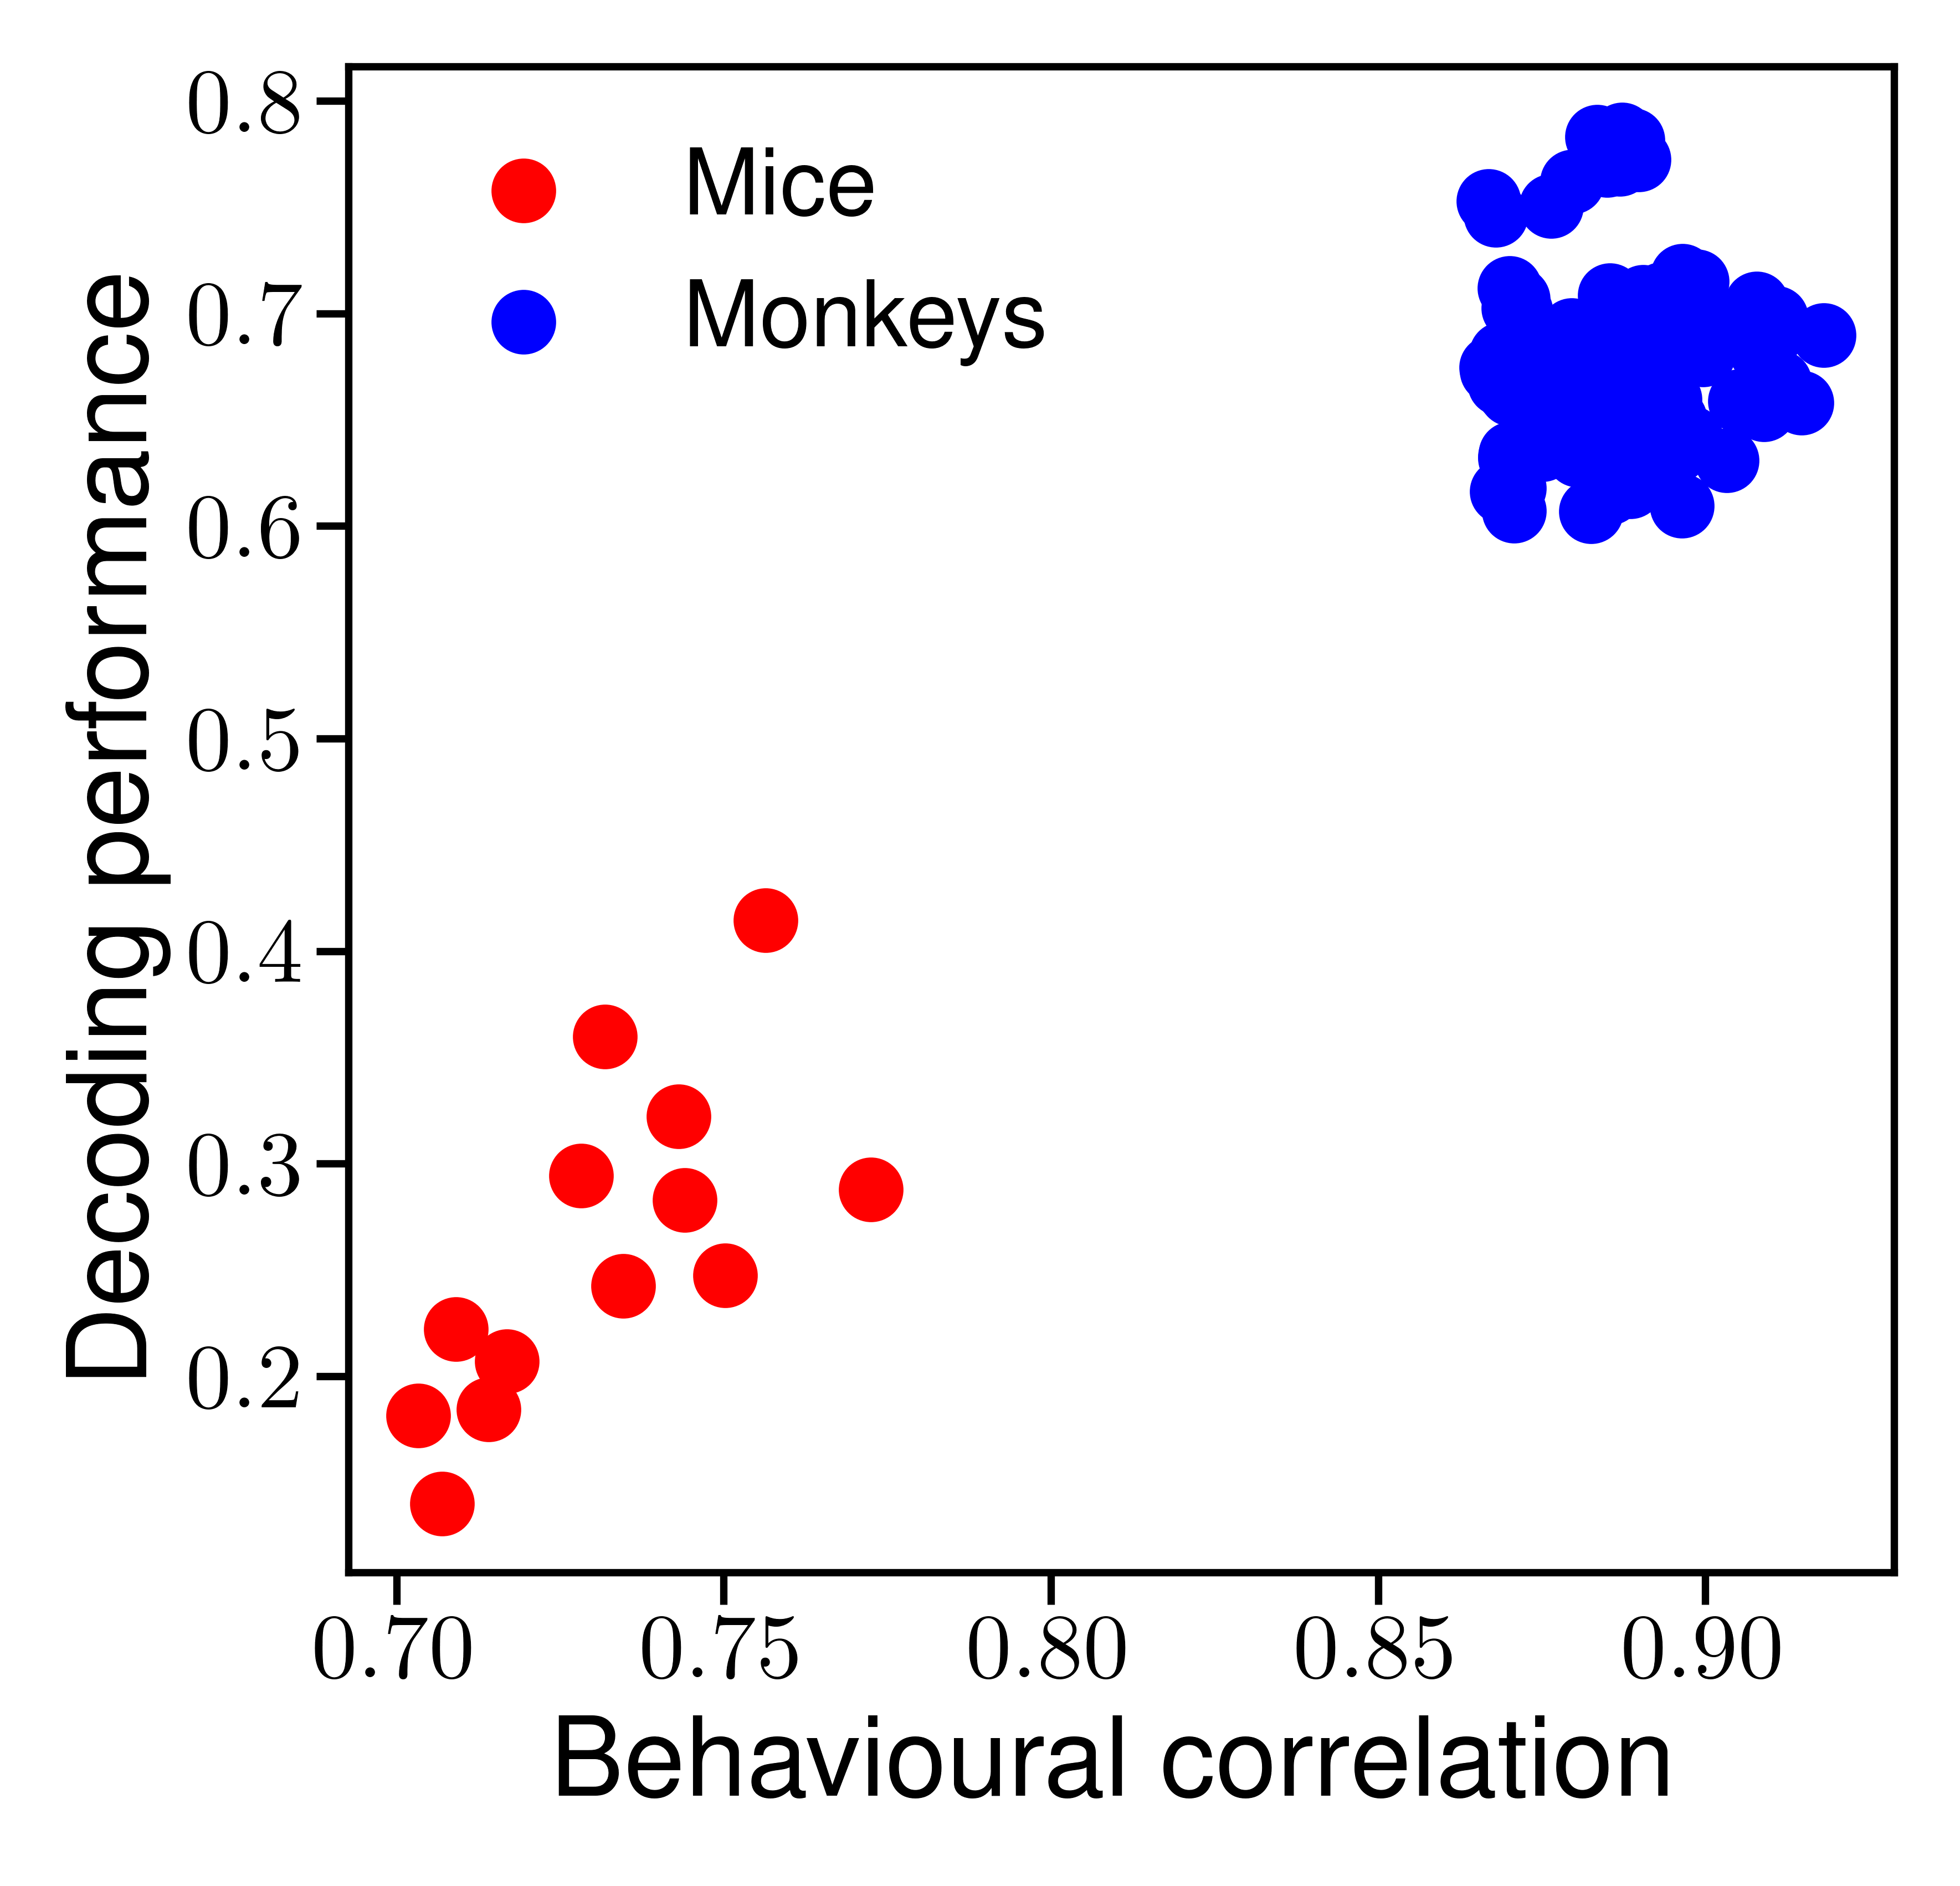

In [10]:
if "__file__" not in dir():     
    fig,ax = plt.subplots(1,1,figsize=(3,3))
    
    ax.scatter(corr_mice[:,1],corr_mice[:,0],color='r', label='Mice', zorder=1)
    ax.scatter(corr_monkey[:,1],corr_monkey[:,0], color='b', label='Monkeys', zorder=0)

    ax.set_xlabel('Behavioural correlation')
    ax.set_ylabel('Decoding performance')
    ax.legend()
    
#     ax.set_title(f'min. behav. corr.: {Behav_corr_TH:0.2f}')
    
    
    fig.savefig(params.figPath / 'traj-decode-corr.pdf', format='pdf', bbox_inches='tight')